# STATS 542: Homework 11
<h4><center> Diego Kleiman (diegoek2) </center></h4>
<h4><center> Due: Monday 11:59 PM CT, Apr 20th </center></h4>

## About HW11

We practice two approaches for solving SVM: quadratic programming and penalized version. The first one utilize the `quadprog` package, while the second one can be solved using the `optim()` function.

## Question 1 [50 Points] Sovling SVM using Quadratic Programming

Install the `quadprog` package (there are similar ones in Python too) and utilize the function `solve.QP` to solve SVM. The `solve.QP` function is trying to perform the minimization problem:
\begin{align}
\text{minimize} & \quad \frac{1}{2} b^T \mathbf{D} b - d^T b, \nonumber \\
\text{subject to} & \quad \mathbf{A}^T b \geq b_0, \nonumber
\end{align}
where $b$ is the unknown parameter. For more details, read the documentation of the \texttt{quadprog} package on CRAN. You should generate the data using the following code (or write a similar code in Python). This is a linearly separable problem. 

```r
  set.seed(4); n <-30; p <- 2
  xpos <- matrix(rnorm(n*p, mean=0, sd=1), n, p)
  xneg <- matrix(rnorm(n*p, mean=3, sd=1), n, p)
  x <- rbind(xpos, xneg)
  y <- matrix(c(rep(1, n), rep(-1, n)))
  
  plot(x,col=ifelse(y>0,"darkorange", "deepskyblue"), pch = 19, xlab = "x1", ylab = "x2")
  legend("topleft", c("Positive","Negative"), 
       col=c("darkorange", "deepskyblue"), pch=c(19, 19), text.col=c("darkorange", "deepskyblue"))
```

**Note:** I ran the R code above to generate the data files `HW11_x.csv` and `HW11_y.csv` and I then import them into Python. The files were attached to this HW.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-poster')
plt.style.use('seaborn-darkgrid')

x_data = np.loadtxt('HW11_x.csv', delimiter=',', skiprows=1)
y_data = np.loadtxt('HW11_y.csv', delimiter=',', skiprows=1)

In [2]:
print(x_data.shape)
print(y_data.shape)

(60, 2)
(60,)


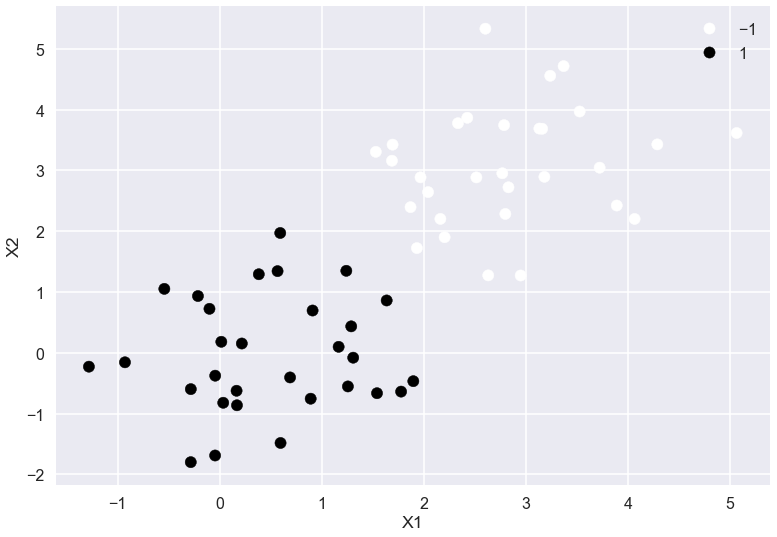

In [3]:
scatter = plt.scatter(x_data[:, 0], x_data[:, 1], c=y_data)
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(*scatter.legend_elements())
plt.show()
plt.close()

### a) [25 points] The Primal Form

Use the formulation defined at page 15 of the `SVM` lecture note. Make sure that you perform the following:

  * Let $b = (\beta_0, \boldsymbol \beta^T)^T$. Then properly define $\mathbf{D}$, $d$, $\mathbf{A}$ and $b_0$ corresponding to this $b$ for our SVM problem.
  * Obtain the solution using the `solve.QP` function, and obtain the decision function. 
  * Plot the decision line, the two margin lines and the support vectors

__Note__: The package requires $\mathbf{D}$ to be positive definite, while it is not true in our case. To address this problem, add $10^{-5}$ to the top-left element of your $\mathbf{D}$ matrix, which is the one corresponding to $\beta_0$. This will make $\mathbf{D}$ invertible. This may affect your results slightly. So be careful when plotting your support vectors.

In [4]:
from qpsolvers import solve_qp

In the Python library `qpsolvers`, the standard form that the quadratic solver uses is
\begin{align}
\text{minimize} & \quad \frac{1}{2} x^T \mathbf{P} x + q^T x, \nonumber \\
\text{subject to} & \quad \mathbf{G} x \leq h \nonumber
\end{align}
plus other constraints that I will not require.

For this reason, my definitions of the variables may look a little bit different.

In [5]:
n = 60
p = 2
e = 1e-5 # Required small constant to make P positive definite
P = np.asarray([[e, 0, 0], [0, 1, 0], [0, 0 ,1]]).astype('double')
q = np.asarray([0, 0, 0]).reshape((p+1,)).astype('double')
G = np.hstack((np.ones((n, 1)), x_data[:, 0].reshape((n, 1)), x_data[:, 1].reshape((n, 1)))) # Each row is (1, xi)
G = (np.tile(y_data, (p+1, 1)).T*G).astype('double') # Now each row is yi*(1, xi)
h = -np.ones(n).reshape((n,)).astype('double') # I need the negative sign because the comparison is inverted

In [6]:
x = solve_qp(P, q, G, h)

In [7]:
print("Solution:", x)

Solution: [-5.69543414  2.0119727   1.63112691]


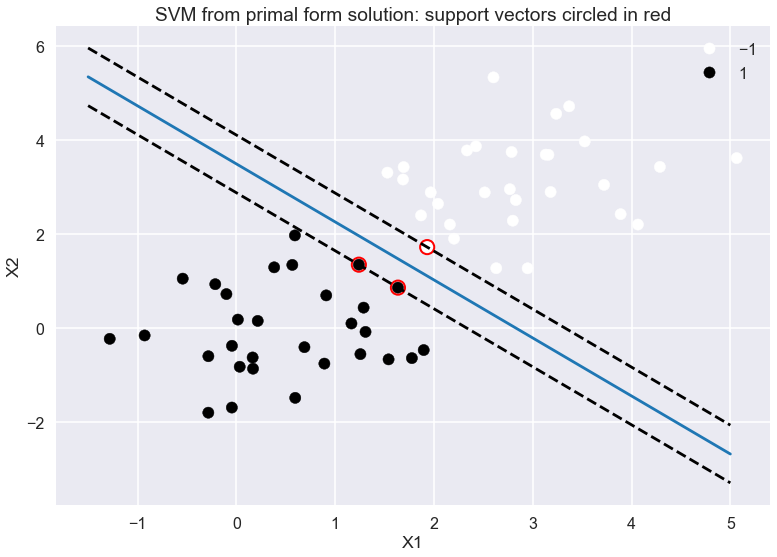

In [8]:
scatter = plt.scatter(x_data[:, 0], x_data[:, 1], c=y_data)
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(*scatter.legend_elements())

decision_line_x = np.linspace(-1.5, 5, 100)
a = -x[1]/x[2]
b = -x[0]/x[2]
decision_line_y = a*decision_line_x + b
plt.plot(decision_line_x, decision_line_y)

margin = 1 / np.linalg.norm(x[1:])
margin_down = decision_line_y - np.sqrt(1 + a**2)*margin
margin_up = decision_line_y + np.sqrt(1 + a**2)*margin
plt.plot(decision_line_x, margin_down, '--', c='black')
plt.plot(decision_line_x,  margin_up, '--', c='black')

support_vectors = [30, 29, 4] # I found these points by looking at the plot
plt.scatter(x_data[:, 0][support_vectors], x_data[:, 1][support_vectors], c="None", edgecolor='red', linewidths=2, s=200)
plt.title("SVM from primal form solution: support vectors circled in red")
plt.show()
plt.close()

### b) [25 points] The Dual Form

Formulate the SVM __dual__ problem in page 24 of the lecture note. Make sure that you perform the following:

  * Let $b = (\alpha_1, \ldots, \alpha_n)^T$. Then properly define $\mathbf{D}$, $d$, $\mathbf{A}$ and $b_0$ corresponding to this $b$ for our SVM problem.
  * Equality constrains can be addressed using the `meq` argument.
  * Obtain the solution using the `solve.QP` function, and convert the solution into $\boldsymbol \beta$ and $\beta_0$. 
  * Plot the decision line, the two margin lines and the support vectors

__Note__: Again, $\mathbf{D}$ is may not be positive definite. This time, add $10^{-6}$ to all diagonal elements to $\mathbf{D}$. This may affect your results slightly. So be careful when plotting your support vectors.

In the Python package `qpsolvers`, the equality constraints take the form
$$\mathbf{A}x = b$$
so I have to add those parameters this time.

My variables will be defined as follows:
* Each entry $(i,j)$ of the matrix $\mathbf{P}$ must be of the form $y_iy_jx_i^Tx_j$. There is no negative sign because the function I call minimizes instead of maximize.
* The vector $q$ should contain $-1$ at every element. It is negative because the function minimizes.
* $\mathbf{G}=-\mathbb{1}_n$ and $h=0$. The negative sign is necessary because the comparison is less or equal than.
* $\mathbf{A}$ is a matrix with elements from the vector $y$ (in the first row, everything else is just $0$) and $b=0$.
* The optimization variable (also termed $x$, do not confuse with data points) is the vector $-\alpha$.

In [9]:
e = 1e-6 # Constant to add to diagonal elements of P
yiyj = np.multiply.outer(y_data, y_data)
xixj = np.empty((n, n))
for i in range(n):
    for j in range(n):
        xixj[i, j] = np.dot(x_data[i], x_data[j]) 
        if (i==j):
            xixj[i, j] += e
P = (yiyj*xixj).astype('double')
q = -np.ones(n).reshape((n,)).astype('double')
G = -np.identity(n).astype('double')
h = np.zeros(n).reshape((n,))
A = np.zeros((n,n))
A[0,:] = y_data
A = A.astype('double')
b = np.zeros(n).reshape((n,))

In [10]:
x = solve_qp(P, q, G, h, A, b)

In [11]:
beta = np.empty(p)
beta[0] = -np.sum(x*y_data*x_data[:, 0]) # The negative sign is because of how I defined the optimization problem
beta[1] = -np.sum(x*y_data*x_data[:, 1])

In [12]:
distances = np.dot(x_data, beta)
distances_negative = distances[np.where(y_data==-1)]
distances_positive = distances[np.where(y_data==1)]
min_point = distances_negative.min()
max_point = distances_positive.max()
beta_0 = -(min_point+max_point)/2

In [13]:
print("Solution:", beta_0, beta)

Solution: -5.69541910840085 [2.01196539 1.63112468]


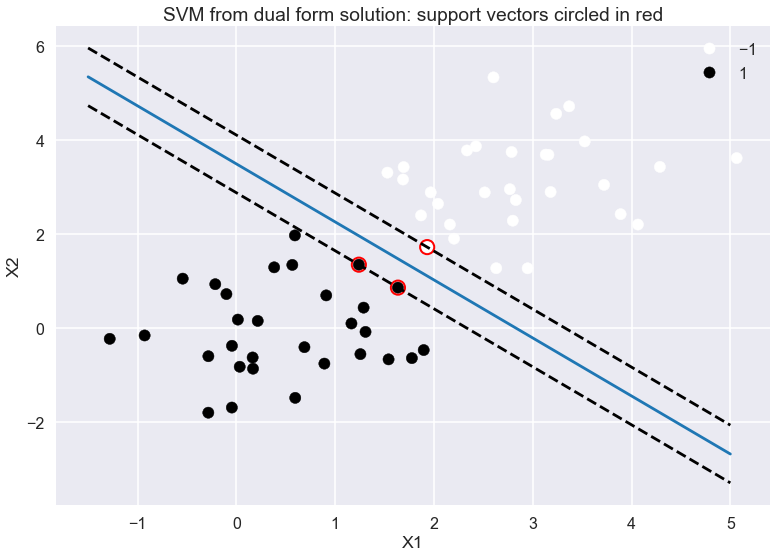

In [14]:
scatter = plt.scatter(x_data[:, 0], x_data[:, 1], c=y_data)
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(*scatter.legend_elements())

decision_line_x = np.linspace(-1.5, 5, 100)
a = -beta[0]/beta[1]
b = -beta_0/beta[1]
decision_line_y = a*decision_line_x + b
plt.plot(decision_line_x, decision_line_y)

margin = 1 / np.linalg.norm(beta)
margin_down = decision_line_y - np.sqrt(1 + a**2)*margin
margin_up = decision_line_y + np.sqrt(1 + a**2)*margin
plt.plot(decision_line_x, margin_down, '--', c='black')
plt.plot(decision_line_x,  margin_up, '--', c='black')

support_vectors = [30, 29, 4] # I found these points by looking at the plot
plt.scatter(x_data[:, 0][support_vectors], x_data[:, 1][support_vectors], c="None", edgecolor='red', linewidths=2, s=200)
plt.title("SVM from dual form solution: support vectors circled in red")
plt.show()
plt.close()

## Question 2 [50 Points] Penalized Loss SVM

We can also perform linear and nonlinear classification using the penalized loss framework. Consider the following logistic loss function:
$$L(y, f(x)) = \log(1 + e^{- y f(x)}).$$
The rest of the job is to solve this optimization problem if given the functional form of $f(x)$. To do this, we will utilize the general-purpose optimization package/function. For example, in `R`, you can use the `optim()` function. Read the documentation of this function (or equivalent ones in Python) and set up the objective function properly to solve for the parameters. If you need an example of how to use the `optim` function, read the corresponding part in the example file provided on our course website [here](https://teazrq.github.io/stat542/other/r-intro.html) (Section 10). 

### Question a) [25 Points] Linear SVM

When $f(x)$ is a linear function, SVM can be solved by optimizing the penalized loss:
$$ \underset{\beta_0, \boldsymbol\beta}{\arg\min} \sum_{i=1}^n L(y_i, \beta_0 + x_i^T \boldsymbol\beta) + \lambda \lVert \beta \rVert^2$$
You should use the data from Question 1, and answer these questions:

  * Write a function to define the penalized loss objective function. The R function `optim()` can run faster if you further define the gradient function. Hence, you should also define the gradient function properly and implement it in the optimization. 
  * Choose a reasonable $\lambda$ value so that your optimization can run properly. In addition, I recommend using the `BFGS` method in optimization. 
  * After solving the optimization problem, plot all data and the decision line
  * If needed, modify your $\lambda$ so that the model fits reasonably well and re-plot. You don't have to tune $\lambda$ as long as you obtain a reasonable decision line.
  * Report your training error. 

In [15]:
from scipy.optimize import minimize

In [16]:
def loss_function(b, X, y, l):
    '''
    Penalized loss with parameters b.
    '''
    f = b[0] + np.dot(X, b[1:])
    loss = (np.log(1 + np.exp(-y*f))).sum() + l*np.linalg.norm(b[1:])**2
    
    return loss

def gradient(b, X, y, l):
    '''
    Penalized loss gradient with parameters b.
    '''
    f = b[0] + np.dot(X, b[1:])
    a = np.exp(-y*f)
    c = 1/(1 + a)*a*(-y)
    
    return np.asarray([
        c.sum(),
        (c*X[:, 0]).sum() + 2*l*b[1],
        (c*X[:, 1]).sum() + 2*l*b[2]
    ]
    )

The gradient of the loss function w.r.t. $[\beta_0 \beta_1 \beta_2]$ is:
$$
\begin{align}
    \nabla L &= \begin{bmatrix}
           \sum_{i}^n (1+e^{-y_i(\beta_0+x_i^T\beta)})e^{-y_i(\beta_0+x_i^T\beta)}(-y_i) \\
           \sum_{i}^n (1+e^{-y_i(\beta_0+x_i^T\beta)})e^{-y_i(\beta_0+x_i^T\beta)}(-y_i)x_{i,1} + 2 \lambda \beta_1 \\
           \sum_{i}^n (1+e^{-y_i(\beta_0+x_i^T\beta)})e^{-y_i(\beta_0+x_i^T\beta)}(-y_i)x_{i,2} + 2 \lambda \beta_2
         \end{bmatrix}
\end{align}
$$

In [17]:
initial_guess = np.asarray([-5.69543414,  2.0119727,   1.63112691])
l = 0.01 # Lambda
extra_args = (x_data, y_data, l)
results = minimize(loss_function, initial_guess, method='BFGS', args=(extra_args), jac=gradient)

In [18]:
results

      fun: 0.7335862679374212
 hess_inv: array([[ 55.92987605, -16.77124436, -16.09497871],
       [-16.77124436,  10.13185288,  -0.12288917],
       [-16.09497871,  -0.12288917,  10.88935804]])
      jac: array([-2.56889489e-07, -6.06881643e-06,  3.56398607e-07])
  message: 'Optimization terminated successfully.'
     nfev: 29
      nit: 27
     njev: 29
   status: 0
  success: True
        x: array([14.92108956, -5.28604525, -4.06330151])

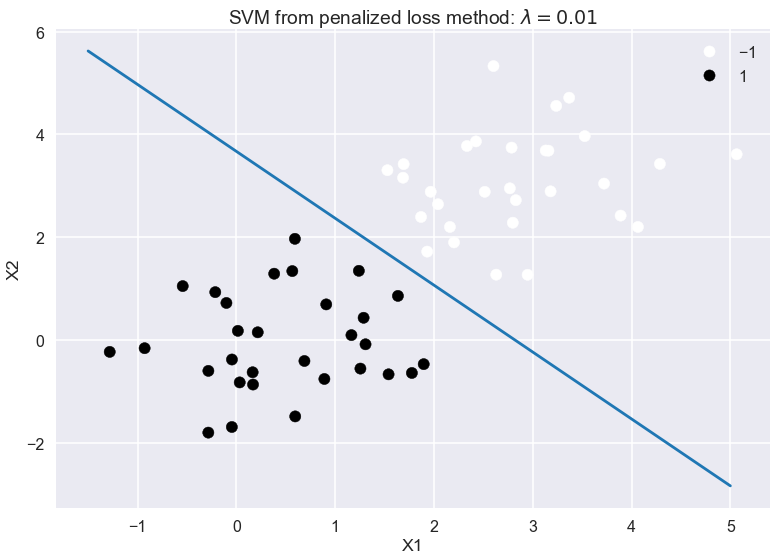

In [19]:
scatter = plt.scatter(x_data[:, 0], x_data[:, 1], c=y_data)
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(*scatter.legend_elements())

decision_line_x = np.linspace(-1.5, 5, 100)
a = -results.x[1]/results.x[2]
b = -results.x[0]/results.x[2]
decision_line_y = a*decision_line_x + b
plt.plot(decision_line_x, decision_line_y)

# No need to plot margins in this question!
# margin = 1 / np.linalg.norm(results.x[1:])
# margin_down = decision_line_y - np.sqrt(1 + a**2)*margin
# margin_up = decision_line_y + np.sqrt(1 + a**2)*margin
# plt.plot(decision_line_x, margin_down, '--', c='black')
# plt.plot(decision_line_x,  margin_up, '--', c='black')

# No need to plot support vectors in this question!
# support_vectors = [30, 29, 4] # I found these points by looking at the plot
# plt.scatter(x_data[:, 0][support_vectors], x_data[:, 1][support_vectors], c="None", edgecolor='red', linewidths=2, s=200)

plt.title("SVM from penalized loss method: $\lambda=0.01$")
plt.show()
plt.close()

In [20]:
print("Training loss:", results.fun)

Training loss: 0.7335862679374212


**Note:** the question asks about "training error." I think this refers to the training loss. The classification error is $0$, because this is a linearly separable problem and all points can be classified correctly (see code below comparing the true and predicted labels). 

In [21]:
np.all(y_data == np.sign(results.x[0] + np.dot(x_data, results.x[1:])))

True

### Question b) [25 Points] Non-linear SVM

You should generate the data using the code provided below (or write similar code in Python):

```r
  set.seed(2)
  n = 300
  p = 2 # dimension

  # Generate the positive and negative examples
  x <- matrix(runif(n*p), n, p)
  side <- (x[, 2] > 0.5 + 0.3*sin(3*pi*x[, 1]))
  y <- sample(c(1, -1), n, TRUE, c(0.9, 0.1))*(side == 1) + sample(c(1, -1), n, TRUE, c(0.1, 0.9))*(side == 0)
  
  plot(x,col=ifelse(y>0,"darkorange", "deepskyblue"), pch = 19, xlab = "x1", ylab = "x2")
  legend("topleft", c("Positive","Negative"), 
       col=c("darkorange", "deepskyblue"), pch=c(19, 19), text.col=c("darkorange", "deepskyblue"))
```

**Note:** I ran the R code above to generate the data files `HW11_x_Q2.csv` and `HW11_y_Q2.csv` and I then import them into Python. The files were attached to this HW.

We will utilize the Reproducing Kernel Hilbert Space (RKHS) to search for our decision function $f(x)$. This means that the decision function can be represented using 
$$\widehat f(x) = \sum_i w_i K(x, x_i)$$
If we plug this into our loss function, it becomes
$$\sum_{i=1}^n L(y_i, \mathbf{w}^T K_i) + \lambda \mathbf{w}^T \mathbf{K} \mathbf{w}$$
where $\mathbf{K}$ is an $n \times n$ kernel matrix, with the $(i,j)$th entry being $K$ is $K(x_i, x_j)$, $K_i$ is the $i$th column of $\mathbf{K}$, and $\mathbf{w} = (w_1, \ldots, w_n)$. For this problem, let's consider the Gaussian kernel $K(\cdot, \cdot)$, which we have used in the kernel regression lecture. For the bandwidth of the kernel function, you can borrow ideas from our previous homework. But you do not need to optimize the bandwidth. Perform the following steps to complete this model fitting:

  * Pre-calculate the kernel matrix $\mathbf{K}$. Fix a $\sigma^2$ value (in the Gaussian density function), as long as your optimization runs properly.
  * Write a function to define the objective function. You should also define the gradient function properly and implement it in the optimization. Type your formula of the gradient function in Latex. 
  * It could be difficult to obtain the decision line itself. However, its relatively easy to obtain the fitted label. Hence, calculate the fitted label (in-sample prediction) of your model and report the classification error. 
  * Plot the data using the fitted labels, and add the true decision line to the plot. This would allow you to visualize (approximately) the decision line. If needed, modify your $\lambda$ so that the model fits reasonably well and re-plot. You don't have to tune $\lambda$ as long as your result is reasonable.

In [22]:
x_data = np.loadtxt('HW11_x_Q2.csv', delimiter=',', skiprows=1)
y_data = np.loadtxt('HW11_y_Q2.csv', delimiter=',', skiprows=1)

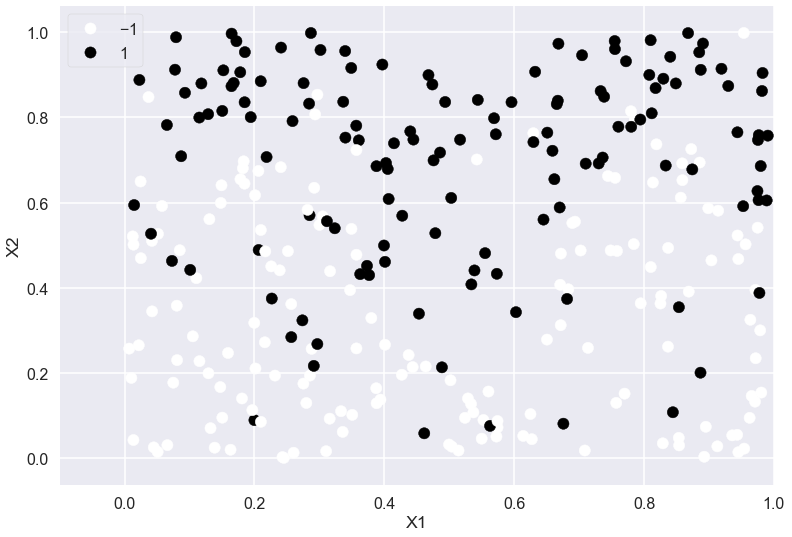

In [23]:
scatter = plt.scatter(x_data[:, 0], x_data[:, 1], c=y_data)
plt.xlabel('X1')
plt.ylabel('X2')
plt.xlim(-0.1, 1)
plt.legend(*scatter.legend_elements(), frameon=True)
plt.show()
plt.close()

In [24]:
def kernel_2D(u, h): # From HW7
    '''
    Multivariate kernel function evaluated at two-dimensional vector u. 
    Parameter h (two-dimensional) controls the bandwidth.
    '''
    assert(len(h) == u.shape[0] == 2) # Avoid passing one-dimensional variable by mistake
    
    return np.exp(-np.sum((u/h)**2)/2)

def silverman_h_2D(x, p=2): # From HW7
    '''
    Return Silverman's h for a given variable x from multivariate training data with p covariates (default 2).
    '''
    n_sample = x.shape[0]
    sigma_hat = np.std(x, ddof=1)
    factor1 = (4/(p+2))**(1/(p+4))
    factor2 = n_sample**(-1/(p+4))
    
    return factor1*factor2*sigma_hat

def loss_function_kernel(w, K, y, l):
    '''
    Penalized loss with parameters w.
    '''
    f = np.dot(K.T, w)
    loss = (np.log(1 + np.exp(-y*f))).sum() + l*np.dot(np.dot(K.T, w), w)
    
    return loss

def gradient_kernel(w, K, y, l):
    '''
    Penalized loss gradient with parameters w.
    '''
    f = np.dot(K.T, w)
    a = np.exp(-y*f)
    output = 1/(1 + a)*a*(-y)*f/w + 2*l*f
    
    return output

The gradient (each component) of the loss function is:

$$
\nabla L = \sum_{i=1}^n \left[(1 + e^{-y_i \mathbf{w}^T\mathbf{K}_i})^{-1}e^{-y_i \mathbf{w}^T\mathbf{K}_i}(-y_i)\mathbf{K}_i \right] + 2\lambda \mathbf{w}^T  \mathbf{K}^T
$$

In [25]:
# Pre-compute kernel matrix
n = x_data.shape[0]
h_2D = (silverman_h_2D(x_data[:, 0]), silverman_h_2D(x_data[:, 1])) # Get bandwidth with Silverman's rule
diff = x_data[np.newaxis,:,:]-x_data[:,np.newaxis,:] # Pairwise differences between components of vectors
kernel_matrix = np.empty((n, n))
kernel_matrix = np.empty((n, n))
for i in range(n):
    for j in range(n):
        # diff array contains xj-xi but I need xi-xj (probably no difference)
        kernel_matrix[i, j] = kernel_2D(diff[j, i], h_2D) 

In [26]:
extra_args = (kernel_matrix, y_data, 0.1)
results = minimize(loss_function_kernel, np.ones(n), method='BFGS', args=(extra_args), jac=gradient_kernel)

In [27]:
predictions = np.sign(np.dot(kernel_matrix.T, results.x))

In [28]:
print("Classification error:", np.count_nonzero(predictions!=y_data)/n)

Classification error: 0.18


The classification error is $18\%$, which is higher than expected (I was expecting something closer to $10\%$ by the method we used to obtain the data points). 

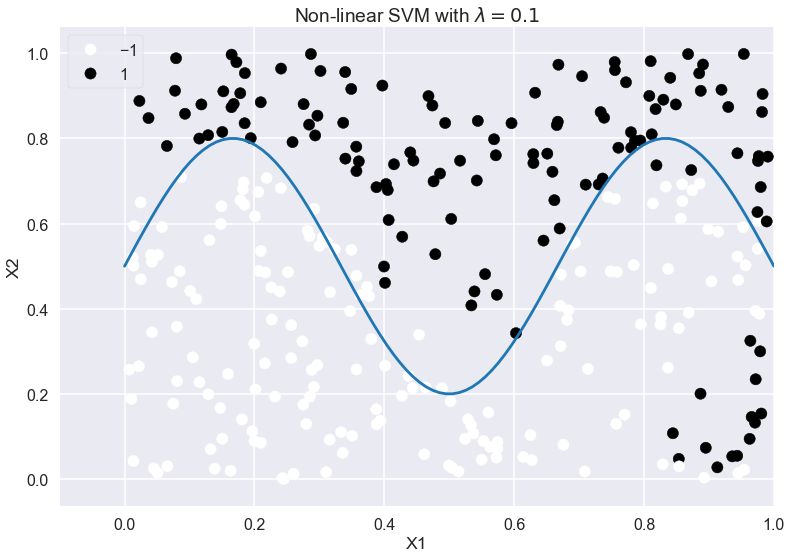

In [29]:
scatter = plt.scatter(x_data[:, 0], x_data[:, 1], c=predictions)
plt.xlabel('X1')
plt.ylabel('X2')
plt.xlim(-0.1, 1)
plt.legend(*scatter.legend_elements(), frameon=True)

decision_line_x = np.linspace(0, 1, 100)
decision_line_y = 0.5 + 0.3*np.sin(3*np.pi*decision_line_x)
plt.plot(decision_line_x, decision_line_y)


plt.title("Non-linear SVM with $\lambda = 0.1$")
plt.show()
plt.close()